In [1]:
%reset -f
%matplotlib inline
%load_ext watermark

In [2]:
import datetime
import enum
import math

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

%watermark -iv -v

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.16.1

numpy     : 1.26.0
polars    : 0.19.6
matplotlib: 3.8.0



# Temperatur

## Clausius-Clapeyron-Gleichung

* https://de.wikipedia.org/wiki/Clausius-Clapeyron-Gleichung
* https://de.wikipedia.org/wiki/Verdampfungsenthalpie
* https://www.spiegel.de/wissenschaft/clausius-clapeyron-gesetz-wie-sich-das-extremwetter-am-mittelmeer-durch-formel-erklaeren-laesst-a-228942e0-99ba-4cf6-b1ce-fc23f79d9372

In [3]:
R = 8.314462  # J mol^-1 K-1
DvapH = 43990  # J mol^-1 @25°C, Vedampfungsenthalpie
K0 = 273.15  # Kelvin

dp_per_degree = math.exp(DvapH / R * (1 / (K0 + 15) - 1 / (K0 + 16)))
dp_per_degree, dp_per_degree**4

(1.0655601500348022, 1.2891750187732336)

## DWD Monthly KL

## 05941 Reit im Winkl

05941 19370401 20230930 686 47.6754 12.4698 Reit im Winkl Bayern

https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/monthly/kl/historical

In [4]:
class C(enum.StrEnum):
    DATE = "Datum"
    TEMP = "Temperatur"

In [5]:
filenames = [
    (
        "temperatur/monatswerte_KL_05941_19370401_20221231_hist"
        "/produkt_klima_monat_19370401_20221231_05941.txt"
    ),
    (
        "temperatur/monatswerte_KL_05941_akt"
        "/produkt_klima_monat_20220301_20230930_05941.txt"
    ),
]

In [6]:
def assign_none(cols: pl.Expr, nan_val: float = -999.0) -> pl.Expr:
    return (
        pl.when(pl.col(pl.Float64) == nan_val)
        .then(None)
        .otherwise(pl.col(pl.Float64))
        .keep_name()
    )


def datetime_col(col: str, fmt: str = "%Y%m%d") -> pl.Expr:
    return (
        pl.col(col)
        .map_elements(lambda x: datetime.datetime.strptime(str(x), fmt))
        .cast(pl.Date)
    )

In [7]:
df = (
    pl.concat(
        [
            pl.scan_csv(
                f,
                separator=";",
                infer_schema_length=10000,
                null_values=["-999", "-999.0"],  # does not work for this CSV
            )
            .rename({"MESS_DATUM_BEGINN": C.DATE, "MO_TT": C.TEMP})
            .select(C.DATE, C.TEMP)
            for f in filenames
        ]
    )
    .group_by(C.DATE)
    .last()
    .with_columns(
        [
            datetime_col(C.DATE),
            assign_none(pl.Float64, -999.0),
        ]
    )
    .sort(C.DATE)
    .collect()
    .upsample(time_column=C.DATE, every="1mo")  # fill missing months with null / None
)
pl.concat([df.head(2), df.tail(2)])

Datum,Temperatur
date,f64
1937-04-01,null
1937-05-01,null
2023-08-01,17.63
2023-09-01,15.67


In [8]:
MONTH_LABELS = [
    "Jan",
    "Feb",
    "Mär",
    "Apr",
    "Mai",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Okt",
    "Nov",
    "Dez",
]

Temperatur
f64
2.065493


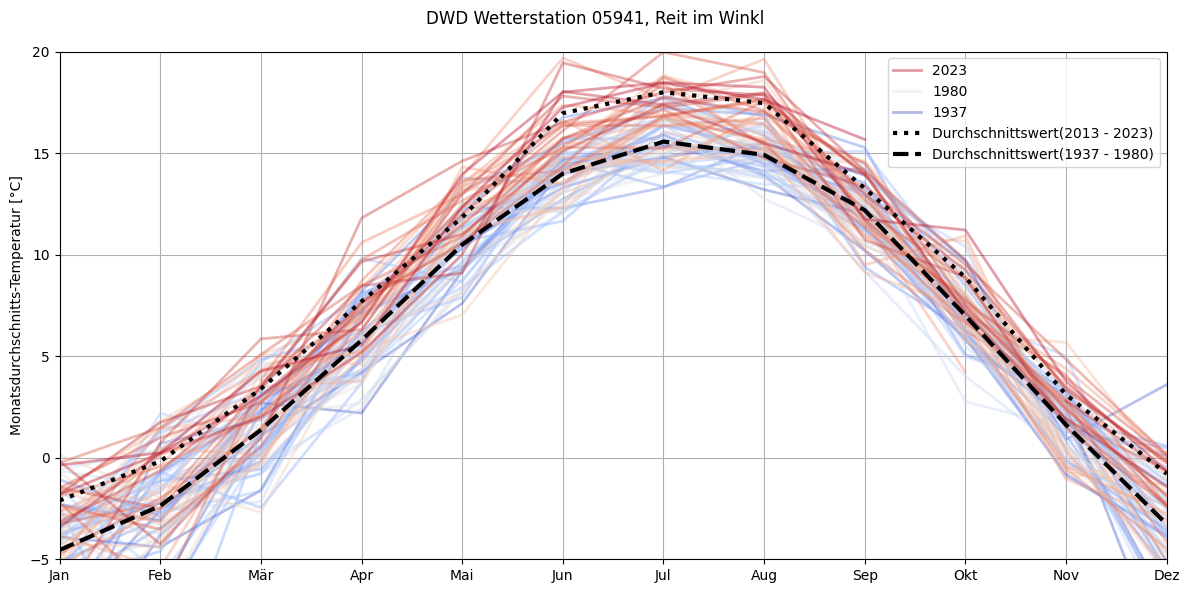

In [9]:
years = df.get_column(C.DATE).dt.year().unique().sort().to_numpy()

cmap = plt.get_cmap("coolwarm")
norm = plt.Normalize(years.min(), years.max())

fig, ax = plt.subplots(figsize=(12, 6), clear=True, layout="tight", num=" ")

for year in years:
    df.filter(pl.col(C.DATE).dt.year() == year).pipe(
        lambda x: ax.plot(
            x.get_column(C.DATE).dt.month(),
            x.get_column(C.TEMP),
            color=cmap(norm(year)),
            alpha=0.4,
            lw=2,
        )
    )

last_10_years = (2013 < pl.col(C.DATE).dt.year()) & (pl.col(C.DATE).dt.year() <= 2023)
first_years = pl.col(C.DATE).dt.year() < 1980


def monthly_mean(df, expr):
    return (
        df.filter(expr)
        .group_by(pl.col(C.DATE).dt.month())
        .agg([pl.col(C.TEMP).mean()])
        .sort(C.DATE)
    )


for linestyle, expr in [("--", first_years), (":", last_10_years)]:
    monthly_mean(df, expr).pipe(
        lambda x: ax.plot(
            x.get_column(C.DATE),
            x.get_column(C.TEMP),
            color="black",
            ls=linestyle,
            lw=3,
        )
    )


# decorate the plot nicely
ax.grid()
ax.set_xticks(
    np.arange(len(MONTH_LABELS) + 1),
    [""] + MONTH_LABELS,
)
ax.set_xlim([1, 12])
ax.set_ylabel("Monatsdurchschnitts-Temperatur [°C]")
ax.set_ylim([-5, 20])
label_lines = [
    Line2D([0], [0], color=cmap(1.0), lw=2, alpha=0.4),
    Line2D([0], [0], color=cmap(0.5), lw=2, alpha=0.4),
    Line2D([0], [0], color=cmap(0.0), lw=2, alpha=0.4),
    Line2D([0], [0], color="k", lw=3, ls=":"),
    Line2D([0], [0], color="k", lw=3, ls="--"),
]
ax.legend(
    label_lines,
    [
        f"{years[-1]}",
        f"{years[len(years)//2]}",
        f"{years[0]}",
        "Durchschnittswert(2013 - 2023)",
        "Durchschnittswert(1937 - 1980)",
    ],
)
ax.get_legend().set_alpha(0.5)
plt.suptitle("DWD Wetterstation 05941, Reit im Winkl")

(monthly_mean(df, last_10_years) - monthly_mean(df, first_years)).select(C.TEMP).mean()

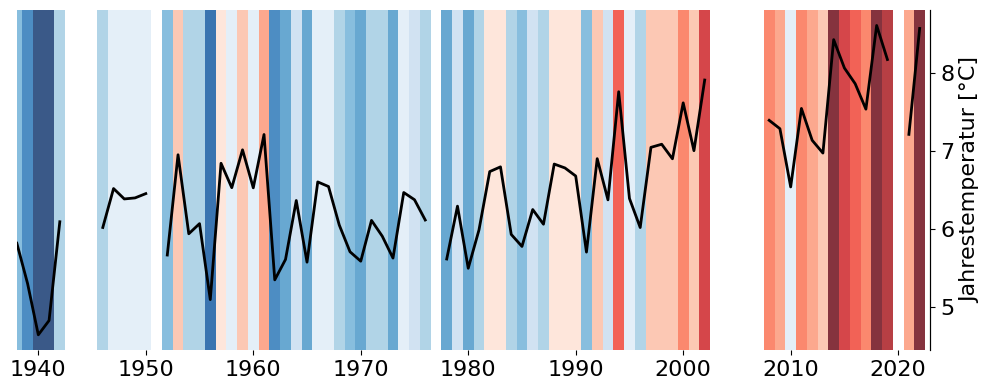

In [10]:
FIRST, LAST = 1938, 2022

cmap = ListedColormap(
    [
        "#08306b",
        "#08519c",
        "#2171b5",
        "#4292c6",
        "#6baed6",
        "#9ecae1",
        "#c6dbef",
        "#deebf7",
        "#fee0d2",
        "#fcbba1",
        "#fc9272",
        "#fb6a4a",
        "#ef3b2c",
        "#cb181d",
        "#a50f15",
        "#67000d",
    ]
)

dy = (
    df.fill_null(np.NaN)  # otherwise years with missing data are not NaN or null
    .group_by(pl.col(C.DATE).dt.year())
    .agg(pl.col(C.TEMP).mean())
    .sort(C.DATE)
    .filter((FIRST <= pl.col(C.DATE)) & (pl.col(C.DATE) <= LAST))
)

with plt.rc_context(rc={"interactive": True, "font.size": 16}):
    fig, ax0 = plt.subplots(figsize=(10, 4), clear=True, layout="tight", num=" ")
    
    col = PatchCollection([Rectangle((x - 0.5, 0), 1, 1) for x in range(FIRST, LAST + 1)])  
    assert (n1 := len(col._paths)) == (n2 := len(dy)), f"{n1} != {n2}"
    col.set_array(dy.get_column(C.TEMP))
    col.set_cmap(cmap)
    col.set_clim(dy.get_column(C.TEMP).min(), dy.get_column(C.TEMP).max())
    col.set_alpha(0.8)
    ax0.add_collection(col)
    ax0.set_ylim(0, 1)
    ax0.set_xlim(FIRST, LAST + 1)
    ax0.yaxis.set_visible(False)
    
    ax1 = ax0.twinx()
    ax1.plot(dy.get_column(C.DATE), dy.get_column(C.TEMP), color="k", linewidth=2)
    ax1.set_ylabel("Jahrestemperatur [°C]")
    from matplotlib.ticker import MaxNLocator
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Hide the right and top spines
    for ax in [ax0, ax1]:
        for direction in ["left", "top", "bottom"]:
            ax.spines[direction].set_visible(False)